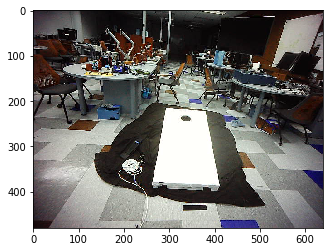

In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import sys
%matplotlib inline

# Load original source
img = cv.imread('socpics/te0.png')
orig = img.copy()
plt.imshow(img)

# Utility functions for dealing with contours
def get_cnt_details(cnt):
    M = cv.moments(cnt)
    details = None
    
    # if the moment is at point 00
    if (M['m00'] != 0):
        details = {}
        details['cx'] = cx = int(M['m10']/M['m00'])
        details['cy'] = cy = int(M['m01']/M['m00'])
        details['area'] = area = cv.contourArea(cnt)
        details['perimeter'] = perimeter = cv.arcLength(cnt,True)
        
        approx = cv.approxPolyDP(cnt,0.01*cv.arcLength(cnt,True),True)
        details['num_vertices'] = len(approx)
    else:
        return None

    if (details['area'] < 16):
        return None
    else:
        return details

def print_cnt_details(cnt):
    cnt_dict = get_cnt_details(cnt)
    
    if (cnt_dict is None):
        return
    
    cx = cnt_dict['cx']
    cy = cnt_dict['cy']
    area = cnt_dict['area']
    perimeter = cnt_dict['perimeter']
    num_vertices = cnt_dict['num_vertices']
    
    print('cx: ', cx, '\tcy: ', cy, '\tarea: ', area, '\tperimeter: ', perimeter, '\tvertices: ', num_vertices)

def cnt_is_circular(cnt):
    cnt_det = get_cnt_details(cnt)
    if (cnt_det is None):
        return False
    area = cnt_det['area']
    perimeter = cnt_det['perimeter']
    num_vertices = cnt_det['num_vertices']
    return True if (num_vertices < 15 and num_vertices > 4) else False

def cnt_is_board(cnt):
    cnt_det = get_cnt_details(cnt)
    if (cnt_det is None):
        return False
    area = cnt_det['area']
    num_vertices = cnt_det['num_vertices']
    approx = cv.approxPolyDP(cnt,0.01*cv.arcLength(cnt,True),True)
    return True if (area > 20000) else False


In [2]:
# Crop the image so we only observe the bottom half when finding contours
height, width, channels = img.shape
print('original_img\nheight: ', height, '\twidth: ', width, '\tchannels: ', channels)
# crop = img[0:width, 200:height]

original_img
height:  480 	width:  640 	channels:  3


cx:  247 	cy:  437 	area:  26217.5 	perimeter:  1142.8843377828598 	vertices:  11
cx:  238 	cy:  469 	area:  16.0 	perimeter:  19.313708305358887 	vertices:  11
cx:  169 	cy:  463 	area:  18.0 	perimeter:  21.656854152679443 	vertices:  6
cx:  149 	cy:  454 	area:  19.0 	perimeter:  22.14213538169861 	vertices:  16
cx:  356 	cy:  435 	area:  672.5 	perimeter:  133.55634891986847 	vertices:  5
cx:  214 	cy:  342 	area:  788.5 	perimeter:  208.75230705738068 	vertices:  22
cx:  215 	cy:  354 	area:  31.5 	perimeter:  27.899494767189026 	vertices:  11
cx:  212 	cy:  341 	area:  30.0 	perimeter:  27.313708305358887 	vertices:  15
cx:  150 	cy:  270 	area:  3774.0 	perimeter:  282.16652059555054 	vertices:  9
cx:  336 	cy:  313 	area:  20540.5 	perimeter:  671.3208485841751 	vertices:  8
cx:  364 	cy:  390 	area:  20.0 	perimeter:  23.656854152679443 	vertices:  6
cx:  344 	cy:  390 	area:  20.0 	perimeter:  23.656854152679443 	vertices:  6
cx:  313 	cy:  389 	area:  24.0 	perimeter:  27.65

Text(0.5, 1.0, 'Cropped With Board/Circle Contours')

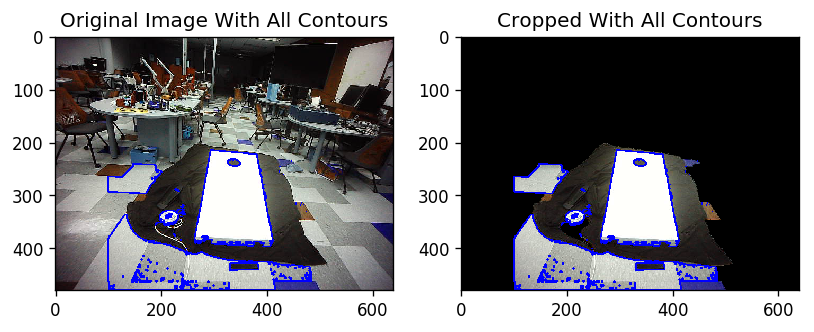

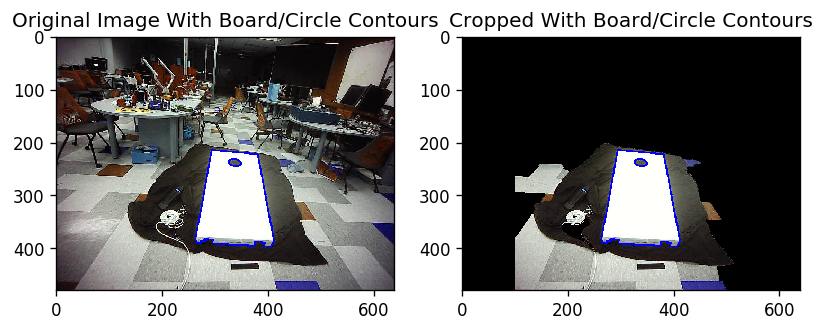

In [3]:
# Do algorithm grabCut(...) to separate foreground from background
mask = np.zeros(img.shape[:2], np.uint8)

bgdModel = np.zeros((1,65), np.float64)
fgdModel = np.zeros((1,65), np.float64)

#rect = (100,100, 450,500) # y1x1,y2x2
rect = (100,200,height,width)
cv.grabCut(img, mask, rect, bgdModel, fgdModel, 5, cv.GC_INIT_WITH_RECT)

mask2 = np.where((mask==2)|(mask==0),0,1).astype('uint8')
img = img*mask2[:,:,np.newaxis]

# threshold binarily
#ret,thresh = cv.threshold(img,127,255,cv.THRESH_BINARY)

# find contours
graysrc = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)

# Get board contour and potential hole contours
board_cnt = None
hole_cnt = None
for cnt in contours:
        
    print_cnt_details(cnt)
    if (cnt_is_circular(cnt)):
        hole_cnt = cnt
    if (cnt_is_board(cnt)):
        board_cnt = cnt

orig_w_cnts = cv.drawContours(orig.copy(), contours, -1, (0,0,255), 2)
crop_w_cnts = cv.drawContours(img.copy(), contours, -1, (0,0,255), 2)

# Plot original image with ALL contours
fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(1,2,1)
plt.imshow(orig_w_cnts)
a.set_title('Original Image With All Contours')
a = fig.add_subplot(1,2,2)
plt.imshow(crop_w_cnts)
a.set_title('Cropped With All Contours')

# Show ONLY supposed board and circle contours
cnts = [x for x in [hole_cnt, board_cnt] if x is not None]
orig_w_cnts = cv.drawContours(orig.copy(), cnts, -1, (0,0,255), 2)
crop_w_cnts = cv.drawContours(img.copy(), cnts, -1, (0,0,255), 2)

fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(1,2,1)
plt.imshow(orig_w_cnts)
a.set_title('Original Image With Board/Circle Contours')
a = fig.add_subplot(1,2,2)
plt.imshow(crop_w_cnts)
a.set_title('Cropped With Board/Circle Contours')


cx:  336 	cy:  313 	area:  20540.5 	perimeter:  671.3208485841751 	vertices:  8
cx:  337 	cy:  238 	area:  233.0 	perimeter:  60.28427076339722 	vertices:  13


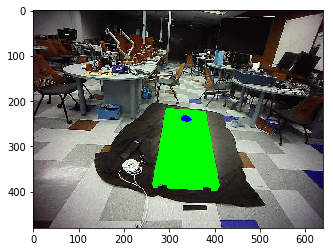

In [4]:
if (board_cnt is not None and hole_cnt is not None):
    img_board_circle_filled = cv.drawContours(orig.copy(), [board_cnt], 0, (0,255,0), cv.FILLED)
    print_cnt_details(board_cnt)
    cv.drawContours(img_board_circle_filled, [hole_cnt], 0, (0,0,255), cv.FILLED)
    print_cnt_details(hole_cnt)
    plt.imshow(img_board_circle_filled)
else:
    print("board_cnt or hole_cnt null")
    print("board contour: "), print_cnt_details(board_cnt)
    print("hole contour: "), print_cnt_details(hole_cnt)
    

"\nfig = plt.figure(figsize=(8,8),dpi=(120))\na = fig.add_subplot(2,2,2)\nplt.imshow(roi_with_hole)\na.set_title('Isolated Cornhole Board Region With Hole Isolated')\n"

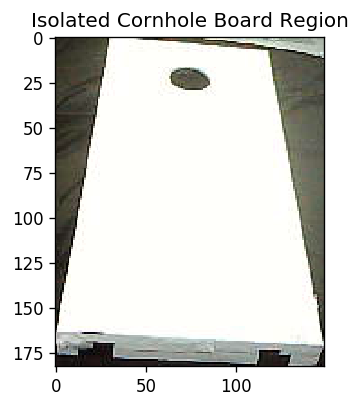

In [5]:
mask = np.zeros(img.shape, np.uint8)
cv.drawContours(mask, [board_cnt], 0, (255,255,255), cv.FILLED)

# Isolate the board area
x,y,w,h = cv.boundingRect(board_cnt)
roi = orig[y:y+h,x:x+w]

fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(2,2,1)
plt.imshow(roi)
a.set_title('Isolated Cornhole Board Region')

# Find the hole contour
graysrc = cv.cvtColor(roi.copy(), cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)

# hole_cnt = [x for x in contours if cnt_is_circular(x)]
# print_cnt_details(hole_cnt)
# roi_with_hole = cv.drawContours(orig.copy(), [hole_cnt], 0, (0,255,0), cv.FILLED)
"""
fig = plt.figure(figsize=(8,8),dpi=(120))
a = fig.add_subplot(2,2,2)
plt.imshow(roi_with_hole)
a.set_title('Isolated Cornhole Board Region With Hole Isolated')
"""

cx:  337 	cy:  238 	area:  233.0 	perimeter:  60.28427076339722 	vertices:  13


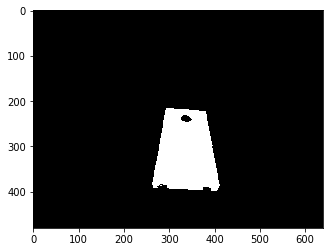

In [6]:
# The purpose of this block is to...
#    Create a mask of the board
#    Extract the board area to find the hole contour
#    Create a mask that doesn't include the hole contour

mask = np.zeros(orig.shape, np.uint8)
cv.drawContours(mask, [board_cnt], 0, (255,255,255), cv.FILLED) # draw the contour of the board in the empty mask

# find contours within board
board_only = np.zeros(orig.shape, np.uint8)
board_only[mask == 255] = orig[mask == 255]
graysrc = cv.cvtColor(board_only, cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(graysrc, 127,255,0)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)

empty_board_cnts = contours

# find the one that's the hole
hole_cnt  = None
hole_area = None
hole_cx = None
hole_cy = None
largest_area = -np.inf
board_dets = get_cnt_details(board_cnt)
board_area = board_dets['area']
for cnt in contours:
    dets = get_cnt_details(cnt)
    if (dets is None):
        continue
    if (dets['area'] > largest_area and dets['area'] != board_area):
        hole_cnt = cnt
        hole_area = dets['area']
        hole_cx = dets['cx']
        hole_cy = dets['cy']

if (hole_cnt is not None):
    cv.drawContours(mask, [hole_cnt], -1, (0,0,0), cv.FILLED)
    print_cnt_details(hole_cnt)
else:
    sys.exit(1) # TODO: is this ok in Jupyter?
    
plt.imshow(mask)

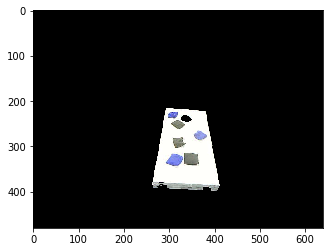

In [7]:
# Isolate the board area in a new image with bags on it (excluding the hole area)
board_w_bags_orig = cv.imread('./socpics/tr3b3.png')
board_w_bags = board_w_bags_orig.copy()

board_area_isolated = board_w_bags & mask

plt.imshow(board_area_isolated)

cx:  336 	cy:  307 	area:  18953.5 	perimeter:  688.634556889534 	vertices:  4
cx:  312 	cy:  330 	area:  764.5 	perimeter:  111.9827550649643 	vertices:  10
cx:  348 	cy:  327 	area:  871.0 	perimeter:  116.62741661071777 	vertices:  8
cx:  320 	cy:  291 	area:  528.5 	perimeter:  100.18376553058624 	vertices:  15
cx:  368 	cy:  276 	area:  432.0 	perimeter:  86.91168737411499 	vertices:  13
cx:  319 	cy:  251 	area:  422.0 	perimeter:  86.56854152679443 	vertices:  8
cx:  337 	cy:  238 	area:  287.0 	perimeter:  65.94112491607666 	vertices:  11
cx:  307 	cy:  230 	area:  294.5 	perimeter:  68.87005722522736 	vertices:  16


new


cx:  312 	cy:  330 	area:  764.5 	perimeter:  111.9827550649643 	vertices:  10
cx:  348 	cy:  327 	area:  871.0 	perimeter:  116.62741661071777 	vertices:  8
cx:  320 	cy:  291 	area:  528.5 	perimeter:  100.18376553058624 	vertices:  15
cx:  368 	cy:  276 	area:  432.0 	perimeter:  86.91168737411499 	vertices:  13
cx:  319 	cy:  251 	area:  422.0 	perimeter

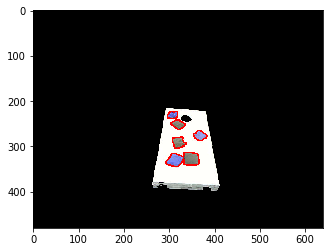

In [8]:
img = board_area_isolated.copy()
graysrc = cv.cvtColor(img.copy(), cv.COLOR_BGR2GRAY)
ret,thresh = cv.threshold(graysrc, 200,255,3)
im2, contours, hierarchy = cv.findContours(thresh,cv.RETR_TREE, 1)

# Print contours found
for cnt in contours:
    dets = get_cnt_details(cnt)
    if (dets is None):
        continue
    print_cnt_details(cnt)
print("\n\nnew\n\n")
    

# Exclude the one with the biggest area (board contour)
biggest_area = -np.inf
cnt_idx = None
for idx,cnt in enumerate(contours):
    dets = get_cnt_details(cnt)
    if (dets is None):
        continue
    curr_area = dets['area']
    if (curr_area > biggest_area):
        cnt_idx = idx
        biggest_area = curr_area
if (cnt_idx is not None):
    del contours[cnt_idx]
    
    
"""
# Exclude the one with the most vertices
most_vertices = -np.inf
cnt_idx = None
for idx,cnt in enumerate(contours):
    dets = get_cnt_details(cnt)
    if (dets is None):
        continue
    curr_vertices = dets['num_vertices']
    if (curr_vertices > most_vertices):
        cnt_idx = idx
        most_vertices = curr_vertices
if (cnt_idx is not None):
    del contours[cnt_idx]
"""

# Remove the contour that was the cornhole board hole
hole_idx = None
for idx,cnt in enumerate(contours):
    dets = get_cnt_details(cnt)
    if (dets is None):
        continue
    cx = dets['cx']
    cy = dets['cy']
    if (cx in range(int(hole_cx)-12,int(hole_cx)+12) and cy in range(int(hole_cy)-10,int(hole_cy)+10)): # TODO!!! Give this some flexibility (+/- 15 pixels maybe)
        hole_idx = idx
if (hole_idx is not None):
    del contours[hole_idx]

# Iterate through the remaining contours
for cnt in contours:
    dets = get_cnt_details(cnt)
    if (dets is None):
        continue
    print_cnt_details(cnt)
    
# Remove extraneous contours (with "none" properties that lead 'get_cnt_details(...)' to return None)
contours = list(filter(lambda x: get_cnt_details(x) is not None, contours))

img_with_cnts = cv.drawContours(img.copy(), contours, -1, (255,0,0), 2)

plt.imshow(img_with_cnts)

In [9]:
def max_difference(xs):
    min_elem = xs[0]
    max_elem = xs[0]
    max_diff = -1

    for elem in xs[1:]:
        min_elem = min(elem, min_elem)
        if elem > max_elem:
            max_diff = max(max_diff, elem - min_elem)
            max_elem = elem

    return max_diff



bag_cnts = contours

# Make a mask for each bag and store them in an array
bag_masks = []
means = []
for cnt in bag_cnts:
    mask = np.zeros(board_w_bags_orig.shape, np.uint8)
    cv.drawContours(mask, [cnt], 0, (255,255,255), cv.FILLED)
    
    masked_img = board_area_isolated & mask
    bag_masks.append(masked_img)
    meanval = cv.mean(masked_img)
    means.append(meanval)

# Find average color of each bag
num_red   = 0
num_black = 0
for bag_mask in bag_masks: # returns BGR instead of RGB
    avg_color_per_row = np.average(bag_mask, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    
    if (max_difference(avg_color) > .05):
        num_red = num_red + 1
    else:
        num_black = num_black + 1

        
print("num_red: ", num_red)
print("num_black: ", num_black)
        
#for mask in bag_masks:
#    mean_val = cv.mean(img.copy(),mask=mask)



num_red:  3
num_black:  3
